Perhaps add data streaming?

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as timer
import pickle

Input_File = 'ChangeDataset622v2.pickle'

def ReadPickle(filename: str) -> dict:
  '''Reads in data from given pickle files, outputs a dictionary'''
  try:
    Data = pd.read_pickle(filename)
  except FileNotFoundError:
    raise FileNotFoundError(f'Error reading {filename}')
  return Data

In [4]:
rmin = 1e-6
rmax = 1.1
nr = 50
r, dr = np.linspace(rmin, rmax, nr, retstep = True)

#Time Grid
tmin = 2.9
tmax = 4.0
nt = 1000
time, dt = np.linspace(tmin, tmax, nt, retstep = True)

In [8]:
print(f"Loading Dataset -- '{Input_File}'")
t_Load1a = timer.time()
Data = ReadPickle(Input_File)
t_Load2a = timer.time()
print(f"Dataset took {round(t_Load2a-t_Load1a,2)}s to load")

D_data = np.array([np.tile(sample['Diffusion'],(1000,1)) for sample in Data])
V_data = np.array([np.tile(sample['Convection'],(1000,1)) for sample in Data])
#R_data = np.array([np.tile(sample['Rho'],(1000,1)) for sample in Data])
#T_data = np.array([np.tile(sample['Time'],(50, 1)).T for sample in Data])
N_data = np.array([Sample['Density'] for Sample in Data])
S_data = np.array([Sample['Source'].T for Sample in Data])

Database = np.array([np.array([D_data[i],V_data[i],N_data[i],S_data[i]]) for i in range(len(Data))])
print(Database.shape)
# del Data
# del D_data, V_data, N_data, S_data, #R_data, T_data

Loading Dataset -- 'ChangeDataset622v2.pickle'
Dataset took 2.13s to load
(10000, 4, 1000, 50)


In [ ]:
N_data.mean(axis=(0,1,2))
arr = []
arr2 = []
for sample in N_data:
    arr.append(sample.max())
    arr2.append(sample.min())
print('Maximums')
print(sorted(arr)[::-1][:10])
print(sorted(arr)[:10])
print('')
print('Minimums')
print(sorted(arr2)[::-1][:10])
print(sorted(arr2)[:10])
#Do a boolean mask
#3e20 max max
#1e17 min min

Maximums
[np.float64(1.9072472638999506e+217), np.float64(5.000819674972365e+178), np.float64(2.4871235671643036e+173), np.float64(2.9878943519655316e+172), np.float64(5.637984504880093e+96), np.float64(4.975371432412916e+96), np.float64(4.648393544429416e+96), np.float64(4.364480058694101e+96), np.float64(2.6161884408072097e+20), np.float64(2.5421443909775475e+20)]
[np.float64(4.481421672513861e+19), np.float64(4.5647910028644475e+19), np.float64(4.6285322256036635e+19), np.float64(4.679711850769299e+19), np.float64(4.688574308726333e+19), np.float64(4.717426163995063e+19), np.float64(4.770072345612592e+19), np.float64(4.787111856597801e+19), np.float64(4.810473782441004e+19), np.float64(4.898829534495168e+19)]

Minimums
[np.float64(2.7872153110575423e+19), np.float64(2.6279138096162517e+19), np.float64(2.6116050854978503e+19), np.float64(2.5346524697288892e+19), np.float64(2.5290695082192007e+19), np.float64(2.490855986348919e+19), np.float64(2.4858289400234484e+19), np.float64(2.483

In [ ]:
# data3 = ReadPickle('ChangeDatasetPre622v3b.pickle')

In [ ]:
# print(data3[0].keys())
# print(data3[0]['D'])


# data4 = []
# for i in range(len(data3)):
#     dataa = {}
#     dataa['Diffusion']= data3[i]['D']
#     dataa['Convection'] = data3[i]['V']
#     dataa['Rho'] = r
#     dataa['Time'] = time
#     dataa['Density'] = data3[i]['N']
#     dataa['Source'] = np.outer(data3[i]['ST'], data3[i]['SR'])
#     data4.append(dataa)
# data4 = np.array(data4)

In [8]:
def WritePickle(data_out: object, filename: str) -> None:
  '''Writes data to pickle file'''
  if not filename.endswith('.pickle'):
    filename += '.pickle'
  with open(filename, 'wb+') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data_out, f, pickle.HIGHEST_PROTOCOL)

# WritePickle(data4, 'ChangeDataset622v3.pickle')

In [ ]:
#This i will code myself later, had gpt code up a basic scaler to use for testing now

#############################GPT CODE FOR SCALING##############################

import numpy as np

# Assume Database is loaded with shape (num_samples, 4, 1000, 50)
print("Original shape:", Database.shape)

# Prepare an empty array to hold the standardized data
Database_channel_standardized = np.empty_like(Database)

# Loop over each channel to standardize it independently.
# Here axis=(0, 2, 3) computes statistics across all samples and the 2D dimensions for the given channel.
channel_means = np.array([np.mean(Database[:, i, :, :]) for i in range(Database.shape[1])])
channel_stds = np.array([np.std(Database[:, i, :, :]) for i in range(Database.shape[1])])
print(f'Channel means: {channel_means}')
print(f'Channel stds: {channel_stds}\n')
for c in range(Database.shape[1]):
    channel_data = Database[:, c, :, :]
    channel_mean = np.mean(channel_data)
    channel_std = np.std(channel_data)
    print(f"Channel {c}: mean = {channel_mean:.4f}, std = {channel_std:.4f}")
    
    Database_channel_standardized[:, c, :, :] = (channel_data - channel_mean) / channel_std
# Optionally, verify the results for one channel:
print("Channel 0 after standardization: mean = {:.4f}, std = {:.4f}".format(
    np.mean(Database_channel_standardized[:, 3, :, :]),
    np.std(Database_channel_standardized[:, 3, :, :])
))
#############################GPT CODE FOR SCALING##############################
# del Database
# del channel_data

Original shape: (10000, 4, 1000, 50)


c:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Channel means: [9.10003494e-001 1.38323948e-001 3.81459775e+208 7.39049369e+018]
Channel stds: [5.14907044e-01 9.82003699e-01            inf 1.66731225e+19]

Channel 0: mean = 0.9100, std = 0.5149
Channel 1: mean = 0.1383, std = 0.9820
Channel 2: mean = 38145977542442592179264181239378414981335380746192783769081060008598925449241917736269755828808401693113852625214525102112342073956481267472831568468526341171735735820029636368062544411237279613151161064882176.0000, std = inf
Channel 3: mean = 7390493685413779456.0000, std = 16673122539862761472.0000
Channel 0 after standardization: mean = 0.0000, std = 1.0000


In [63]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Convolutional Variational Autoencoder:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=640):
        super(VariationalAutoencoder, self).__init__()
        
        # Encoder:
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=(4,2), padding=1),# -> (16, 250, 25)
            nn.SELU(),
            nn.Conv2d(16, 64, kernel_size=3, stride=(4,2), padding=1),# -> (64, 63, 13)
            nn.SELU(),
            nn.Conv2d(64, 256, kernel_size=3, stride=(4,2), padding=1),# -> (256, 16, 7)
            nn.SELU(),
            nn.Conv2d(256, 1024, kernel_size=3, stride=(4,2), padding=1),# -> (1024, 4, 4)
            nn.SELU()
        )
        
        #Flattened conv feature size is 1024*4*4 = 16,448
        self.fc1 = nn.Linear(1024*4*4,1024)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
        
        #Decoder:
        self.decoder_fc = nn.Linear(latent_dim, 1024*4*4)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=3, stride=(4,2), padding=1, output_padding=(3,0)),# -> (256, 16, 7)
            nn.SELU(),
            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=(4,2), padding=1, output_padding=(2, 0)),# -> (64, 63, 13)
            nn.SELU(),
            nn.ConvTranspose2d(64, 16, kernel_size=3, stride=(4,2), padding=1, output_padding=(1, 0)),# -> (16, 250, 25)
            nn.SELU(),
            nn.ConvTranspose2d(16, 4, kernel_size=3, stride=(4,2), padding=1, output_padding=(3, 1))# -> (4, 1000, 50)
        )
    
    def encode(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0),-1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(-1,1024,4,4)
        x = self.decoder_conv(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar

#Updated Loss Function using Mean Squared Error (MSE)
def vae_loss(decoded, original, mu, logvar, r, dt=1.0, dr=1.0, lambda_pinn=1e-3):

    #Unpack the decoded output
    D_hat = decoded[:,0:1]   #Diffusion
    v_hat = decoded[:,1:2]   #Convection
    N_hat = decoded[:,2:3]   #Density
    S_hat = decoded[:,3:4]   #Source

    #Find datatype and device
    dtype, device = N_hat.dtype, N_hat.device
    
    # tandard VAE loss
    N_true = original[:,2:3]
    MSE = F.mse_loss(N_hat, N_true, reduction='mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    #Collapse 2d transport arrays
    D1 = D_hat[:,:,0,:].unsqueeze(2)
    v1 = v_hat[:,:,0,:].unsqueeze(2)

    #Put rho array into proper form
    r = torch.tensor(r, dtype=torch.float32, device=device)
    r_b = r.view(1,1,1,-1).to(N_hat.device)

    #Finite Difference Kernels
    kernel_dt = torch.tensor(
        [[[[ -1/(2*dt) ], [ 0.], [ 1/(2*dt) ]]]],
        device=N_hat.device,
        dtype=dtype
    )  # shape (1,1,3,1)
    kernel_dr = torch.tensor(
        [[[[ -1/(2*dr), 0.,  1/(2*dr) ]]]],
        device=N_hat.device,
        dtype = dtype
    )  # shape (1,1,1,3)

    #dndt with Neumann BC
    x = F.pad(N_hat, (0,0, 1,1), mode='replicate')
    dndt = F.conv2d(x, kernel_dt)

    #Advective Term (1/r)*d_r(rvn)
    f_adv = r_b*v1*N_hat
    x = F.pad(f_adv, (1,1, 0,0), mode='replicate')  # pad radial dim
    dfr = F.conv2d(x, kernel_dr)
    adv = dfr/r_b

    #Diffusive Term: (1/r)*d_r(rD*d_r(n))
    x      = F.pad(N_hat, (1,1, 0,0), mode='replicate')
    dn_dr  = F.conv2d(x, kernel_dr)
    f_diff = r_b * D1 * dn_dr
    x      = F.pad(f_diff, (1,1, 0,0), mode='replicate')
    dfd    = F.conv2d(x, kernel_dr)
    diff   = dfd / r_b

    #Residual using Source term
    Resid = dndt + adv - diff - S_hat
    PINN = torch.mean(Resid**2)

    return MSE + KLD + lambda_pinn*PINN, PINN, MSE, KLD

#Custom Dataset to handle the numerical array
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        return self.data[idx], 0


In [65]:
#Training Setup
latent_dim = 640
batch_size = 32
lr_vae = 1e-3  #1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(latent_dim=640).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr_vae)

#Dataloaders
dataset = CustomDataset(Database_channel_standardized)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    total_samples = 0
    epoch_loss = 0
    epoch_loss_mse = 0
    epoch_loss_kld = 0
    epoch_loss_pinn = 0
    
    for batch_data, _ in dataloader:
        bs = batch_data.size(0)
        batch_data = batch_data.to(device)
        decoded_data, mu, logvar = vae(batch_data)
        
        loss, pinn, mse, kld = vae_loss(decoded_data, batch_data, mu, logvar, r, dt, dr, lambda_pinn=1e-1)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()*bs
        total_samples += bs
    
    avg_loss = epoch_loss / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}]: Average Loss: {avg_loss:.4f}" + ' '*45)
    print(f'Epoch [{epoch+1}/{num_epochs}]: MSE: {mse:.4f}, KLD: {kld:.4f}, PINN: {pinn:.4f}\n')
    
    prog_str = (f"Epoch [{epoch+1}/{num_epochs}]: "
                f"Avg: {avg_loss:.4f}, MSE: {mse:.4f}, KLD: {kld:.4f}, PINN: {pinn:.4f}")
    print(prog_str, end='\r', flush=True)
    
print("Training complete!" + ' '*70)

Epoch [1/100]: Average Loss: 18581829.8574                                             
Epoch [1/100]: MSE: 0.6287, KLD: 0.0010, PINN: 9.7831

Epoch [2/100]: Average Loss: 1.1929                                             
Epoch [2/100]: MSE: 0.9794, KLD: 0.0001, PINN: 0.0723

Epoch [3/100]: Average Loss: 1.0072                                             
Epoch [3/100]: MSE: 0.7045, KLD: 0.0002, PINN: 0.0042

Epoch [4/100]: Average Loss: 1.0007                                             
Epoch [4/100]: MSE: 0.8671, KLD: 0.0000, PINN: 0.0008

Epoch [5/100]: Average Loss: 1.0006                                             
Epoch [5/100]: MSE: 1.0256, KLD: 0.0000, PINN: 0.0006

Epoch [6/100]: Average Loss: 1.0010                                             
Epoch [6/100]: MSE: 0.6922, KLD: 0.0000, PINN: 0.0002

Epoch [7/100]: Average Loss: 1.0002                                             
Epoch [7/100]: MSE: 0.9446, KLD: 0.0000, PINN: 0.0032

Epoch [8/100]: Average Loss: 1.0001      

In [ ]:
id_num = np.random.randint(10000)
torch.save(vae, f'VAE_Pretrained_PINN_{id_num}.pt')

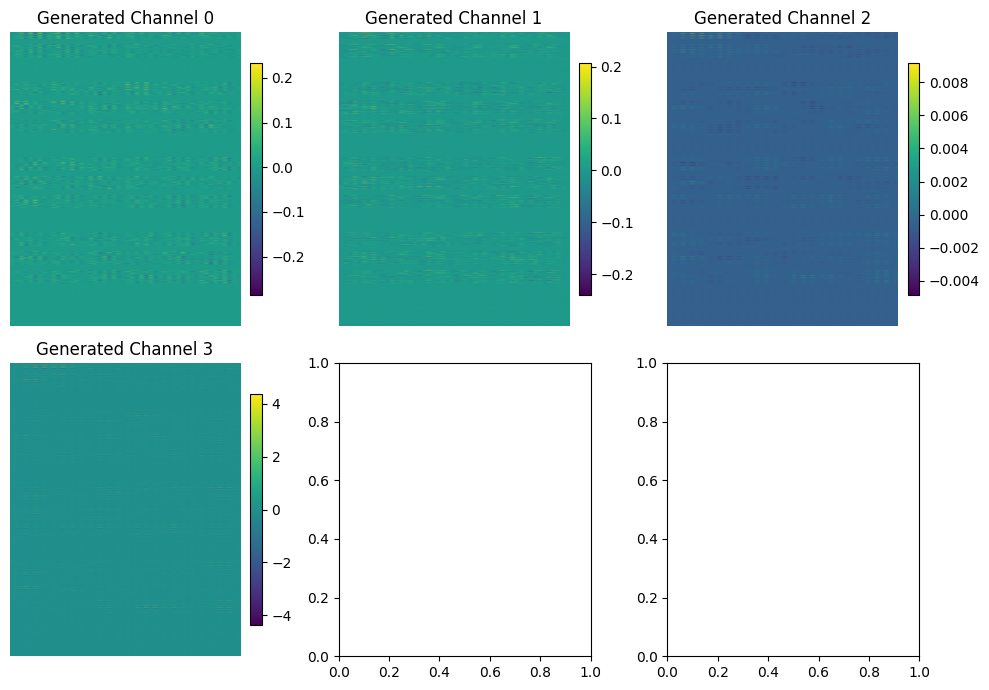

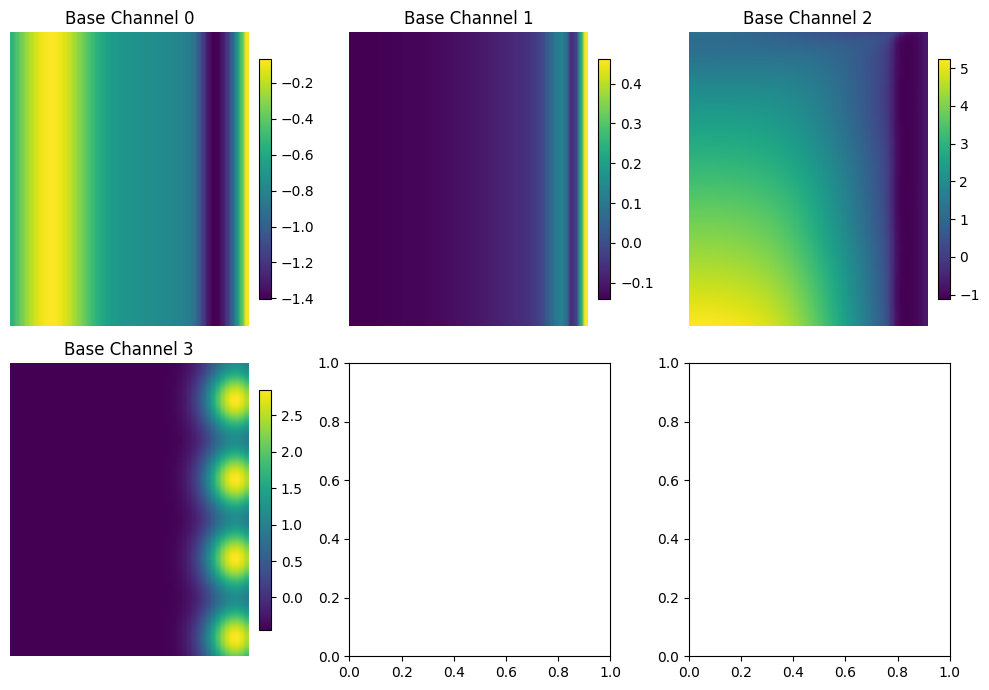

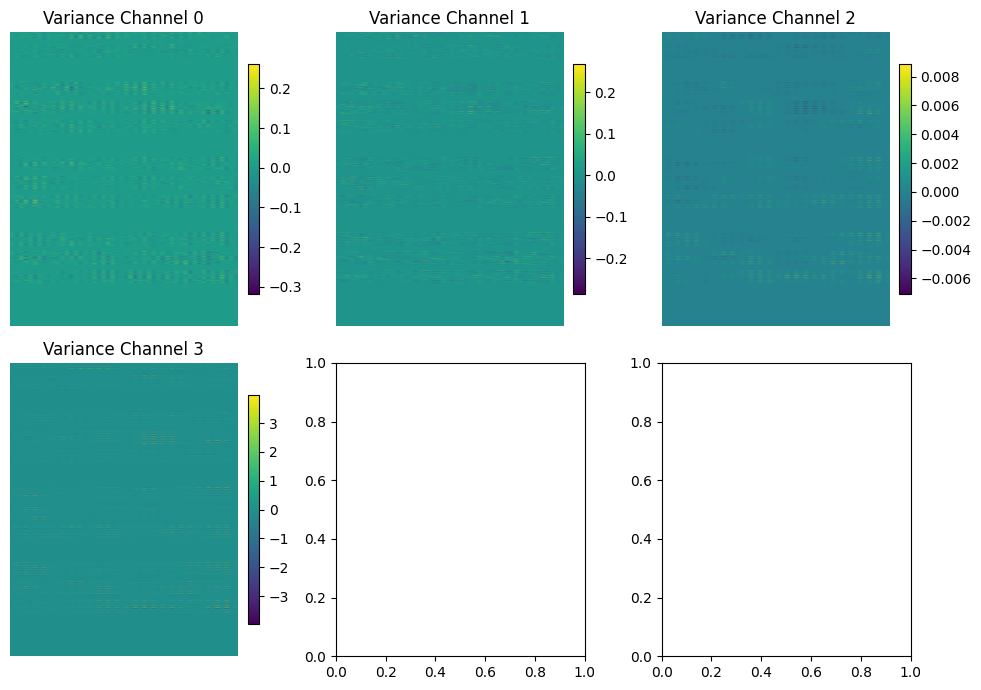

In [ ]:
import torch
import matplotlib.pyplot as plt

#Set the VAE to evaluation mode
vae.eval()

#Specify the latent dimension (should match what you used during training)
latent_dim = 640

#Sample a single latent vector from a standard normal distribution and decode it.
with torch.no_grad():
    z1 = torch.randn(1, latent_dim, device=device)  #Sample one latent vector
    z2 = torch.randn(1, latent_dim, device=device)  #Sample one latent vector
    generated1 = vae.decode(z1)
    generated2 = vae.decode(z2)

#Remove the batch dimension and move the tensor to CPU
sample1 = generated1.squeeze(0).cpu()
sample2 = generated2.squeeze(0).cpu()
sample1_np = sample1.numpy()
sample2_np = sample2.numpy()

#Plotting
fig, axs = plt.subplots(2, 3, figsize=(10,7))
axs = axs.ravel()


for i in range(4):
    im = axs[i].imshow(sample1_np[i], aspect='auto', cmap='viridis')
    axs[i].set_title(f'Generated Channel {i}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

fig.savefig(f'Images/GeneratedChannelsv{id_num}.png', dpi=300, bbox_inches='tight')
    
fig2, axs2 = plt.subplots(2, 3, figsize=(10,7))
axs2 = axs2.ravel()

for i in range(4):
    im = axs2[i].imshow(Database_channel_standardized[np.random.randint(1000)][i], aspect='auto', cmap='viridis')
    axs2[i].set_title(f'Base Channel {i}')
    axs2[i].axis('off')
    fig2.colorbar(im, ax=axs2[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

fig.savefig(f'Images/BaseChannel{id_num}.png', dpi=300, bbox_inches='tight')

fig, axs = plt.subplots(2, 3, figsize=(10,7))
axs = axs.ravel()

for i in range(4):
    im = axs[i].imshow((sample1_np[i] - sample2_np[i]), aspect='auto', cmap='viridis')
    axs[i].set_title(f'Variance Channel {i}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

fig.savefig(f'Images/VarianceChannel{id_num}.png', dpi=300, bbox_inches='tight')


In [ ]:
#Poolng, fix noise, etc.